## 12. Дифференциальные уравнения. Робин Гуд
Робин Гуд бросает камень с привязанным к нему письмом
через бойницу крепостной стены в открытое окно, стоящего за ней замка:
``` 
                    стена                    замок
                    _____ 
                   [     ]                  ______ 
                   [     ]                 [      ]
                   [_____]                 [      ]
                   бойница                 [      ]
                    _____                  [      ]
                   [     ]                 [      ]
                   [     ]                   окно ]
                   [     ]                 [      ]
                   [     ]                 [      ]
.                  [     ]                 [      ]
 \0 _              [     ]                 [      ]
  I                [     ]                 [      ]
 / \               [     ]                 [      ]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
```

Смоделируйте полет камня с помощью функции `integrate.solve_ivp`.
Рассмотрите следующие события (events): 
   1. камень упал на землю, не долетев до окна (либо до, либо после стены);
   2. камень не попал в бойницу (ударился о стену);
   3. камень застрял в бойнице (стукнулся о «пол» или «потолок» бойницы и упал внутри нее); 
   4. камень стукнулся о  стену замка (не попав в окно);
   5. камень попал в окно 
      (для простоты считаем, что и крепостная стена, и замок очень высокие
      и сверху через них камень перебросить нельзя).
При наступлении каждого из этих событий дальнейшее интегрирование прекращаются. 

Написать функцию, на вход которой подаются:
  * параметры:
    масса камня,
    расстояние от Робин Гуда до стены,
    толщину стены (равную длине бойницы),
    расстояние от земли до бойницы и высоту бойницы,
    расстояние от стены до замка,
    расстояние от земли до окна и высоту окна,

  * начальные условия:
    угол броска и начальную скорость камня.

Программа должна отображать «вид сбоку» (многоугольники можно нарисовать с помощью функций
`matplotlib.patches.Patch`) и траекторию полета.

# Код программы


In [20]:
import math
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import patches

g = 9.8  
initial_x = 0  # начальное положение x
initial_y = 2  # начальное положение y
initial_velocity = 15  # начальная скорость
launch_angle = 75  # угол броска
wall_distance = 6  # расстояние до стены
wall_width = 1  # ширина стены
bottom_embrasure_height = 10  # высота низа бойницы
embrasure_height = 5  # высота бойницы
castle_distance = 5  # расстояние от стены до замка
castle_window_height = 7  # высота окна замка
castle_wall_width = 1  # ширина стены замка (только для рисунка)
window_height = 2  # высота окна


# Вычисление координаты x в зависимости от времени
def calculate_x_coordinate(time, initial_x, initial_velocity_x):
    return initial_x + initial_velocity_x * time


# Вычисление координаты y в зависимости от времени
def calculate_y_coordinate(time, initial_y, initial_velocity_y):
    return initial_y + initial_velocity_y * time - 0.5 * g * time ** 2


# Вычисление времени, необходимого для достижения заданной координаты x
def calculate_time_x(coordinate_x, initial_x, initial_velocity_x):
    return (coordinate_x - initial_x) / initial_velocity_x


# Вычисление времени, необходимого для достижения заданной координаты y
def calculate_time_y(coordinate_y, initial_y, initial_velocity_y):
    time1 = (initial_velocity_y - math.sqrt(initial_velocity_y ** 2 + 2 * g * (initial_y - coordinate_y))) / g
    time2 = (initial_velocity_y + math.sqrt(initial_velocity_y ** 2 + 2 * g * (initial_y - coordinate_y))) / g
    return time1, time2


# Вычисление времени до достижения максимальной высоты по оси y
def calculate_time_to_reach_max_height(initial_velocity_y):
    return initial_velocity_y / g


def model(initial_x, initial_y, initial_velocity, launch_angle,
          wall_distance, wall_width, bottom_embrasure_height, embrasure_height,
          castle_distance, castle_height, castle_wall_width, window_height):
    # Вычисление координат стен и окон

    wall_end = wall_distance + wall_width
    castle_dist = wall_end + castle_distance
    castle_end = castle_dist + castle_wall_width
    wall_top_height = bottom_embrasure_height + embrasure_height
    castle_top_height = castle_height + window_height

    # Перевод угла в радианы и вычисление проекций начальной скорости
    angle = math.pi * launch_angle / 180
    v0_x = initial_velocity * math.cos(angle)
    v0_y = initial_velocity * math.sin(angle)

    # Вычисление координаты y при достижении стены
    time_x = calculate_time_x(wall_distance, initial_x, v0_x)
    x_in_wall = calculate_x_coordinate(time_x, initial_x, v0_x)
    y_in_wall = calculate_y_coordinate(time_x, initial_y, v0_y)

    # Вычисление координаты y при покидании стены
    time_x = calculate_time_x(wall_end, initial_x, v0_x)
    x_out_wall = calculate_x_coordinate(time_x, initial_x, v0_x)
    y_out_wall = calculate_y_coordinate(time_x, initial_y, v0_y)

    # Вычисление координаты y при достижении замка
    time_x = calculate_time_x(castle_dist, initial_x, v0_x)
    x_in_castle = calculate_x_coordinate(time_x, initial_x, v0_x)
    y_in_castle = calculate_y_coordinate(time_x, initial_y, v0_y)

    # Вычисление времени до достижения максимальной высоты по оси y
    time_max = calculate_time_to_reach_max_height(v0_y)
    x_max = calculate_x_coordinate(time_max, initial_x, v0_x)
    y_max = calculate_y_coordinate(time_max, initial_y, v0_y)

    # Создание объектов для рисования стен и окон
    wall_bottom = patches.Rectangle((wall_distance, 0),
                                    wall_width, bottom_embrasure_height,
                                    edgecolor='blue', facecolor='red')
    wall_top = patches.Rectangle((wall_distance, bottom_embrasure_height + embrasure_height),
                                 wall_width, bottom_embrasure_height,
                                 linewidth=3, edgecolor='blue', facecolor='red')
    castle_bottom = patches.Rectangle((wall_end + castle_distance, 0),
                                      castle_wall_width, castle_height,
                                      edgecolor='blue', facecolor='red')
    castle_top = patches.Rectangle((wall_end + castle_distance, castle_height + window_height),
                                   castle_wall_width, bottom_embrasure_height,
                                   edgecolor='blue', facecolor='red')

    # Создание графика и добавление объектов для рисования
    fig = plt.figure(figsize=(16, 12))
    _, ax = plt.subplots()
    ax.add_patch(wall_bottom)
    ax.add_patch(wall_top)
    ax.add_patch(castle_bottom)
    ax.add_patch(castle_top)
    pass

    # Флаг попадания
    hit = True

    # Проверка различных сценариев полета объекта и определение интервала времени ts
    if y_in_wall < bottom_embrasure_height:
        # Полет ниже бойницы
        time_y = calculate_time_y(0, initial_y, v0_y)[1]
        if calculate_x_coordinate(time_y, initial_x, v0_x) < wall_distance:
        # Не долетел до стены
            ts = np.linspace(0, time_y, 500)
        else:
        # Долетел до стены, но не попал
            ts = np.linspace(0, calculate_time_x(wall_distance, initial_x, v0_x), 500)
        hit = False
    elif y_in_wall > wall_top_height:
        # Полет выше бойницы
        ts = np.linspace(0, calculate_time_x(wall_distance, initial_x, v0_x), 500)
        hit = False
    elif y_out_wall < bottom_embrasure_height:
    # Ударился о нижнюю часть бойницы
        ts = np.linspace(0, calculate_time_x(wall_distance, initial_x, v0_x), 500)
        hit = False
    elif y_out_wall > wall_top_height:
    # Ударился о верхнюю часть бойницы
        ts = np.linspace(0, calculate_time_x(wall_distance, initial_x, v0_x), 500)
        hit = False
    elif y_in_castle < castle_height:
    # Полет ниже окна замка
        ts = np.linspace(0, calculate_time_x(castle_dist, initial_x, v0_x), 500)
        hit = False
    elif y_in_castle > castle_top_height:
    # Полет выше окна замка
        time_y = calculate_time_y(0, initial_y, v0_y)[1]
        if calculate_x_coordinate(time_y, initial_x, v0_x) < castle_dist:
            ts = np.linspace(0, time_y, 500)
        else:
            ts = np.linspace(0, calculate_time_x(castle_dist, initial_x, v0_x), 500)
        hit = False
    elif (y_in_wall > bottom_embrasure_height and y_in_wall < wall_top_height and
          y_out_wall > bottom_embrasure_height and y_out_wall < wall_top_height and
          x_max > wall_distance and x_max < wall_end and
          y_max >
          wall_top_height):
    # Попал в окно замка
        ts = np.linspace(0, calculate_time_x(wall_end, initial_x, v0_x), 500)
        hit = False
    else:
        ts = np.linspace(0, calculate_time_x(castle_end, initial_x, v0_x), 500)

    # Вычисление координат x и y для заданного интервала времени ts
    x_coords = [calculate_x_coordinate(t, initial_x, v0_x) for t in ts]
    y_coords = [calculate_y_coordinate(t, initial_y, v0_y) for t in ts]

    # Построение траектории полета
    ax.plot(x_coords, y_coords, color=(0, 0, 0))
    
    plt.show()
    pass

    return hit


# Пролетел бойницу но не попал в окно

<Figure size 1152x864 with 0 Axes>

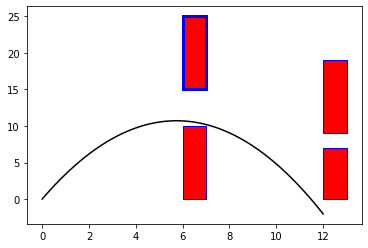

In [39]:
v0 = 15
launch_angle = 75
st = model(initial_x, initial_x, v0, launch_angle,
          wall_distance, wall_width, bottom_embrasure_height, embrasure_height,
          castle_distance, castle_window_height, castle_wall_width, window_height)

# Не долетел до бойницы

<Figure size 1152x864 with 0 Axes>

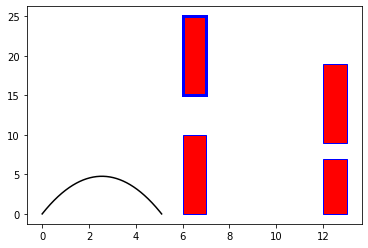

In [40]:
v0 = 10
launch_angle = 75
st = model(initial_x, initial_x, v0, launch_angle,
          wall_distance, wall_width, bottom_embrasure_height, embrasure_height,
          castle_distance, castle_window_height, castle_wall_width, window_height)

# Ударился о стену

<Figure size 1152x864 with 0 Axes>

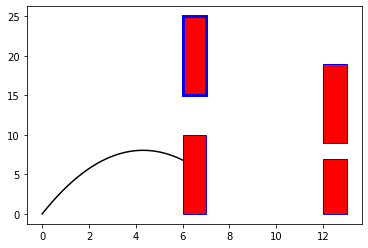

In [41]:
v0 = 13
launch_angle = 75
st = model(initial_x, initial_x, v0, launch_angle,
          wall_distance, wall_width, bottom_embrasure_height, embrasure_height,
          castle_distance, castle_window_height, castle_wall_width, window_height)

# Попал в окно

<Figure size 1152x864 with 0 Axes>

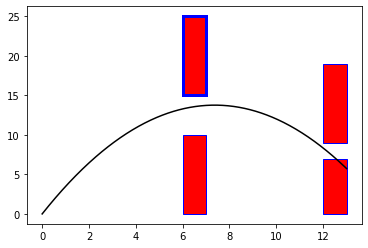

In [43]:
v0 = 17
launch_angle = 75
st = model(initial_x, initial_x, v0, launch_angle,
          wall_distance, wall_width, bottom_embrasure_height, embrasure_height,
          castle_distance, castle_window_height, castle_wall_width, window_height)

# Камень пролетел над окном

<Figure size 1152x864 with 0 Axes>

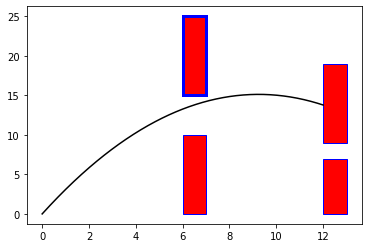

In [50]:
v0 = 18
launch_angle = 73
st = model(initial_x, initial_x, v0, launch_angle,
          wall_distance, wall_width, bottom_embrasure_height, embrasure_height,
          castle_distance, castle_window_height, castle_wall_width, window_height)